In [1]:
import re
import string
from unicodedata import normalize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import gensim
import pandas as pd
import spacy
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np

In [2]:
nlp = spacy.load('es_core_news_sm')
stemmer = SnowballStemmer("spanish")

In [3]:
esp_stop = stopwords.words('spanish')
esp_stop.remove('estado')

In [4]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([stemmer.stem(word.lemma_) for word in doc if word.lemma_ not in esp_stop])

In [5]:
def preprocess(df, column):
    articles = df

    articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
    articles[column] = articles[column].str.strip()
    articles[column] = articles[column].str.replace('\n', ' ')
    articles[column] = articles[column].str.replace('nº', ' ')
    articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
    articles[column] = articles[column].apply(lambda x: " ".join(x.split()))
    articles[column] = articles[column].apply(
        lambda x: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
                         normalize("NFD", x), 0, re.I))

    articles = articles[[len(str(x).split()) > 2 for x in articles[column]]]
    return articles.reset_index(drop=True)

### Apertura archivo y preprocesamiento

In [6]:
with open("data/nc_ch_chapters.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_chapters = data.split("--capitulo--")

In [7]:
df_charperts = pd.DataFrame(list_chapters, columns=["chapter"])

In [8]:
df_charperts_p = preprocess(df_charperts, "chapter")

In [9]:
corpus_chapters = [word_tokenize(lemmatizer(i)) for i in df_charperts_p["chapter"]]

In [10]:
dict_corpus_chapter = corpora.Dictionary(corpus_chapters)

dtm_gensim_chapters = [dict_corpus_chapter.doc2bow(i) for i in corpus_chapters]
dtm_gensim_tfidf_chapters = models.TfidfModel(dtm_gensim_chapters)[dtm_gensim_chapters]

In [11]:
lda_gensim_chapters = gensim.models.ldamodel.LdaModel
ldamodel_gensim_chapters = lda_gensim_chapters(
    dtm_gensim_tfidf_chapters,
    num_topics = 8,
    passes = 1000,
    id2word = dict_corpus_chapter,
    random_state = 0,
    eval_every = None,
    alpha = 'auto'
)

In [12]:
ldamodel_gensim_chapters.print_topics(
    num_words = 15,
    num_topics = 49
)

[(0,
  '0.002*"agu" + 0.001*"banc" + 0.001*"inconstitucional" + 0.001*"central" + 0.001*"president" + 0.001*"contralori" + 0.001*"miner" + 0.001*"agenci" + 0.001*"juez" + 0.001*"hidric" + 0.001*"republ" + 0.001*"proteg" + 0.001*"fiscal" + 0.001*"cuenc" + 0.001*"penal"'),
 (1,
  '0.000*"emplac" + 0.000*"empresarial" + 0.000*"determinar" + 0.000*"diversificacion" + 0.000*"domin" + 0.000*"economi" + 0.000*"eficient" + 0.000*"elect" + 0.000*"emergent" + 0.000*"denunci" + 0.000*"finanz" + 0.000*"fech" + 0.000*"funcionari" + 0.000*"fisc" + 0.000*"delegar"'),
 (2,
  '0.002*"juez" + 0.002*"president" + 0.001*"ministr" + 0.001*"tribunal" + 0.001*"vicepresident" + 0.001*"republ" + 0.001*"jef" + 0.001*"vecinal" + 0.001*"asumir" + 0.001*"jurisdiccional" + 0.001*"armad" + 0.001*"doming" + 0.001*"declaracion" + 0.001*"calif" + 0.001*"diput"'),
 (3,
  '0.002*"electoral" + 0.001*"incident" + 0.001*"sufrag" + 0.001*"democraci" + 0.001*"registr" + 0.001*"inici" + 0.001*"ciudadan" + 0.001*"consejer" + 0.

In [13]:
df_topic_term_chapters = pd.DataFrame(
    ldamodel_gensim_chapters.get_topics(),
    columns=ldamodel_gensim_chapters.id2word.values(),
    index=[f'topic{i}' for i in range(ldamodel_gensim_chapters.num_topics)]
)

df_topic_term_chapters.sort_values(by=df_topic_term_chapters.columns.values.tolist(), ascending=False)

,acces,accion,activ,acto,actu,adecu,administracion,adopt,alcanz,alto,...,undecim,usted,veinticinc,venc,vers,vist,¿,“,”,…
topic6,0.000584,0.000584,0.000373,0.000358,0.000357,0.000425,0.000343,0.000393,0.000358,0.000364,...,0.000343,0.000343,0.000343,0.000343,0.000343,0.000343,0.000343,0.000343,0.000343,0.000343
topic5,0.000422,0.000422,0.000384,0.000384,0.000443,0.000443,0.000375,0.000416,0.000485,0.000395,...,0.000375,0.000375,0.000375,0.000375,0.000375,0.000375,0.000375,0.000375,0.000375,0.000375
topic0,0.000408,0.000589,0.000391,0.000377,0.000359,0.000375,0.000359,0.000423,0.000414,0.000376,...,0.000359,0.000359,0.000359,0.000359,0.000359,0.000359,0.000359,0.000359,0.000359,0.000359
topic7,0.000402,0.000383,0.000397,0.000374,0.000411,0.000459,0.000337,0.000360,0.000389,0.000387,...,0.000378,0.000422,0.000378,0.000378,0.000378,0.000378,0.000422,0.000511,0.000511,0.000378
topic2,0.000392,0.000410,0.000374,0.000376,0.000388,0.000394,0.000358,0.000446,0.000358,0.000376,...,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358,0.000358
topic1,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,...,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390
topic4,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,...,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390,0.000390
topic3,0.000376,0.000376,0.000391,0.000376,0.000376,0.000402,0.000376,0.000376,0.000376,0.000392,...,0.000376,0.000376,0.000376,0.000376,0.000376,0.000376,0.000376,0.000376,0.000376,0.000376


In [14]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda_chapters = CoherenceModel(model=ldamodel_gensim_chapters, texts=corpus_chapters, dictionary=dict_corpus_chapter, coherence='c_v')
coherence_lda_chapters = coherence_model_lda_chapters.get_coherence()
print('\nCoherence Score: ', coherence_lda_chapters)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim_chapters.log_perplexity(dtm_gensim_tfidf_chapters))  # a measure of how good the model is. lower the better.


Coherence Score:  0.40227931723117344

Perplexity:  -12.87343204406161


In [15]:
def get_max(doc):
    idx, l = zip(*doc)
    return idx[np.argmax(l)] , l[np.argmax(l)]

tpc = [get_max(doc) for doc in ldamodel_gensim_chapters[dtm_gensim_tfidf_chapters]]
df_tpc = pd.DataFrame(tpc, columns =['topico', 'prop'])
df_tpc['doc'] = df_tpc.index
df_tpc[df_tpc["topico"]==6].sort_values('prop',ascending=False).head()

,topico,prop,doc
1,6,0.998348,1
5,6,0.997944,5


In [16]:
df_tpc.sort_values('prop',ascending=False).head()

,topico,prop,doc
1,6,0.998348,1
5,6,0.997944,5
6,7,0.997876,6
10,7,0.997864,10
4,7,0.997722,4


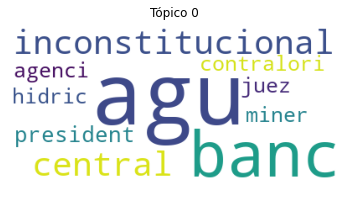

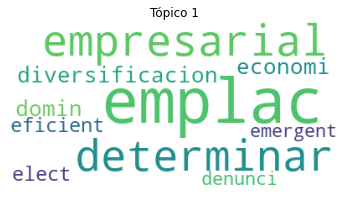

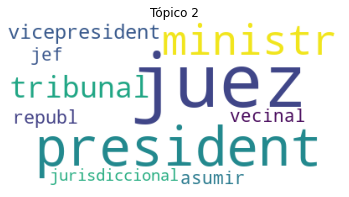

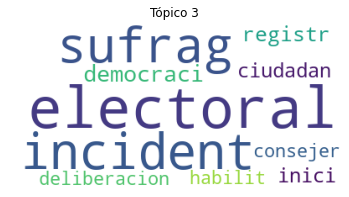

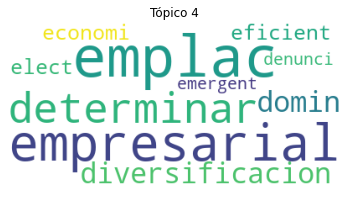

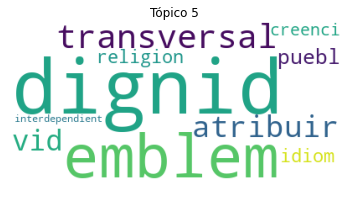

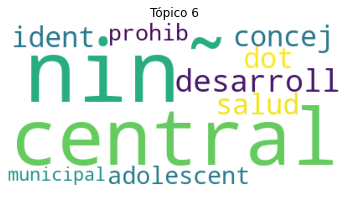

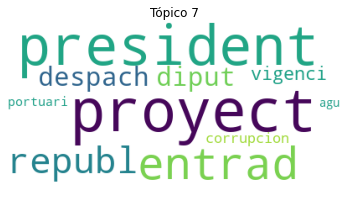

In [17]:
for i in range(0, 8):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim_chapters.show_topic(i, 10)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

In [22]:
df_charperts_p.iloc[5]

chapter    el estado se organiza territorialmente en enti...
Name: 5, dtype: object

In [23]:
dist_indices = [topic[0] for topic in ldamodel_gensim_chapters[dtm_gensim_chapters[5]]]
dist_contrib = [topic[1] for topic in ldamodel_gensim_chapters[dtm_gensim_chapters[5]]]

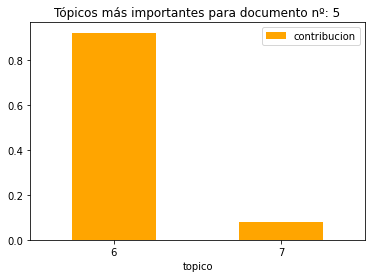

In [24]:
distribucion_topicos = pd.DataFrame({'topico':dist_indices,'contribucion':dist_contrib })
distribucion_topicos.sort_values('contribucion', ascending=False, inplace=True)

ax = distribucion_topicos.plot.bar(
    y='contribucion',
    x='topico',
    rot=0,
    color="orange",
    title = "Tópicos más importantes para documento nº: " + str(5)
)

In [25]:
for ind, topico in distribucion_topicos.iterrows():
    print("Topico: " + str(int(topico.topico)))
    palabras = ', '.join([palabra[0] for palabra in ldamodel_gensim_chapters.show_topic(topicid=int(topico.topico))])
    print(palabras, "\n")

Topico: 6
niñ, central, desarroll, concej, salud, ident, dot, adolescent, prohib, municipal 

Topico: 7
proyect, president, entrad, republ, diput, despach, vigenci, corrupcion, portuari, agu 

